In [215]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
import datetime

plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
N_replicates = 100
settlingTime = 2 ** 0
E_max = 3

tlens = 2 ** np.arange(5,9)
obs_noise = np.array([0.0,0.1,0.2,0.3])
pro_noise = np.array([0.0,0.1,0.2,0.3])

t = np.linspace(0,1,num=tlens[0])

In [265]:
## Drivers ##

r = lambda t: 3.75 # 3 + 0.75 * t / tlen
# b1 = lambda t: 3 + 5 * t / end
# rho = lambda t : 28 # + 10 * t / end
# sigma = lambda t : 10 # + 10 * t / end
# beta = lambda t : 5.0 / 3.0 + 3*t/end
# F = lambda t : 5 + 15 * t / end
# N = 5

In [266]:
## Time Series Generation ##
tlen=tlens[3]
settlingTime = tlen
x0 = rand.rand(1)
pro=0.015
Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime,process_noise=pro)

# x0 = rand.random(N)
# x0 = np.array([1,0.5,7]) - rand.random(3) * 0.1

# Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]
# Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]

## Add Noise ##
# noise_magnitude = 0.1
# Xr += rand.random((Xr.shape[0],1)) * np.ptp(Xr) * noise_magnitude

In [269]:
log_std = np.std(Xr)

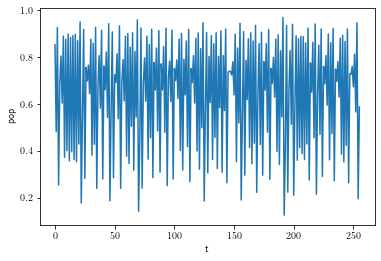

In [268]:
plotTS(Xr)

In [225]:
no_noise_var = np.var(Xr)

Text(0.5, 1.0, 'Logistic Map Process Noise Ratio')

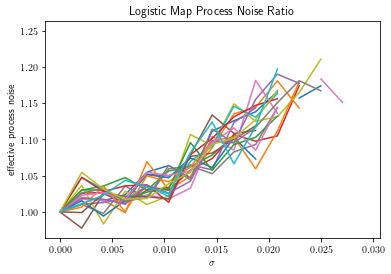

In [229]:
for i in range(20):
    process_noises = np.linspace(0,0.05,num=25)
    variances = np.array([np.var(generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime,process_noise=x)) for x in process_noises]) / no_noise_var
    plt.plot(process_noises,variances)
    
plt.xlabel(r"$\sigma$")
plt.ylabel("effective process noise")
plt.title("Logistic Map Process Noise Ratio")

In [ ]:
process_noise_levels = 2 ** np.arange(-5,-2)

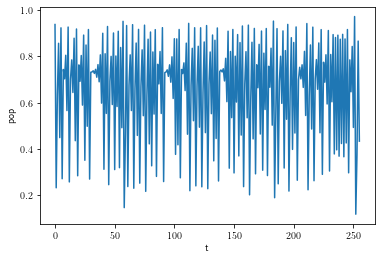

In [239]:
plotTS(Xr)

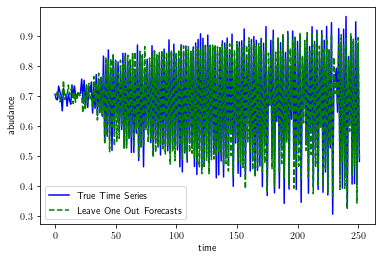

In [114]:
delta_agg, r_sqrd_EDM, ns_area = get_delta_agg(Xr, 3, return_forecast_skill=True)

In [115]:
delta_agg

15.205263974399516

In [116]:
r_sqrd_EDM

3.027901439999985

In [129]:
N_replicates = 10
for tlen in tlens:
    for obs in obs_noise:
        for pro in pro_noise:
            logistic_stationary = np.zeros((N_replicates,3))
            logistic_nonstationary = np.zeros((N_replicates,3))
            
            for i in range(N_replicates):
                x0 = rand.rand(1)
                
                r = lambda t: 3.75
                Xr_s = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime,process_noise=0.12*pro)
                r = lambda t: 3 + 0.75 * t / tlen
                Xr_ns = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime,process_noise=0.12*pro)
                
                Xr_s += (rand.random((tlen,1))-0.5) * np.ptp(Xr_s) * obs
                Xr_ns += (rand.random((tlen,1))-0.5) * np.ptp(Xr_ns) * obs
                
                delta_agg_s, theta_agg_s, r_sqrd_s = get_delta_agg(Xr_s, E_max, return_forecast_skill=True)
                delta_agg_ns, theta_agg_ns, r_sqrd_ns = get_delta_agg(Xr_ns, E_max, return_forecast_skill=True)
                
                logistic_stationary[i,0] = delta_agg_s
                logistic_stationary[i,1] = theta_agg_s
                logistic_stationary[i,2] = r_sqrd_s
                logistic_nonstationary[i,0] = delta_agg_ns
                logistic_nonstationary[i,1] = theta_agg_ns
                logistic_nonstationary[i,2] = r_sqrd_ns
                
            np.savetxt(f"logistic_results/logistic_stationary_{tlen}_{obs}_{pro}.csv",logistic_stationary, fmt="%0.4f,%0.4f,%0.4f")
            np.savetxt(f"logistic_results/logistic_nonstationary_{tlen}_{obs}_{pro}.csv",logistic_nonstationary, fmt="%0.4f,%0.4f,%0.4f")

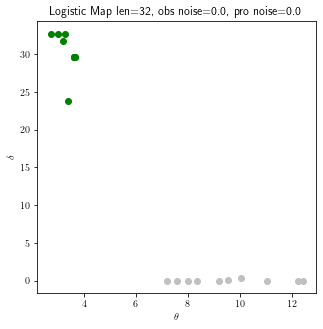

In [143]:
time_series_length = tlens[0]
observation_noise = obs_noise[0]
process_noise = pro_noise[0]

S = np.loadtxt(f"logistic_results/logistic_stationary_{time_series_length}_{observation_noise}_{process_noise}.csv",delimiter=",")
NS = np.loadtxt(f"logistic_results/logistic_nonstationary_{time_series_length}_{observation_noise}_{process_noise}.csv",delimiter=",")

fig, ax = plt.subplots(1,figsize=(5,5))
ax.scatter(S[:,1],S[:,0],color="silver")
ax.scatter(NS[:,1],NS[:,0],color="green")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\delta$")
ax.set_title(f"Logistic Map len={time_series_length}, obs noise={observation_noise}, pro noise={process_noise}")

plt.show()

In [252]:
# Time Series Length versus Nonstationarity Rate
T_list = (50, 200)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
N_replicates = 100
E_max = 2

# Time Series Length, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(T_list) * len(r_list), 5))
results_index = 0

for T in T_list:
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime)
            
            delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([T, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
# np.savetxt(f"logistic_T_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

In [253]:
results = np.loadtxt(f"logistic_T_vs_NS_Rate.csv", delimiter=",")

In [263]:
np.mean(results[np.logical_and(results[:,0] == 50, results[:,1]==1),2] > 0.1)

1.0

In [283]:
# Observation Noise versus Nonstationarity Rate
T = 200
obs_list = (0.0,0.1,0.2,0.3)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
N_replicates = 100
E_max = 2

# log_std is calculated as the standard deviation on a stationary logistic map series with T=200 and r=3.75

# observation noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(obs_list) * len(r_list), 5))
results_index = 0

for o_n in obs_list:
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime)
            Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]
            
            delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([o_n, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"logistic_obsnoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

In [ ]:
# Process Noise versus Nonstationarity Rate
T = 200
pro_list = (0.0,0.015)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
N_replicates = 100
E_max = 2

# process noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(pro_list) * len(r_list), 5))
results_index = 0

for p_n in pro_list:
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            
            # generate time series, regenerating if it explodes
            Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime, process_noise=p_n)
            while np.any(np.isnan(Xr)):
                Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime, process_noise=p_n)
        
            delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([p_n, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"logistic_pronoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")